In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from scipy import signal
from scipy.interpolate import griddata

import sys
sys.path.append("/home/j/j_mens07/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import nanonets_utils
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
%matplotlib inline

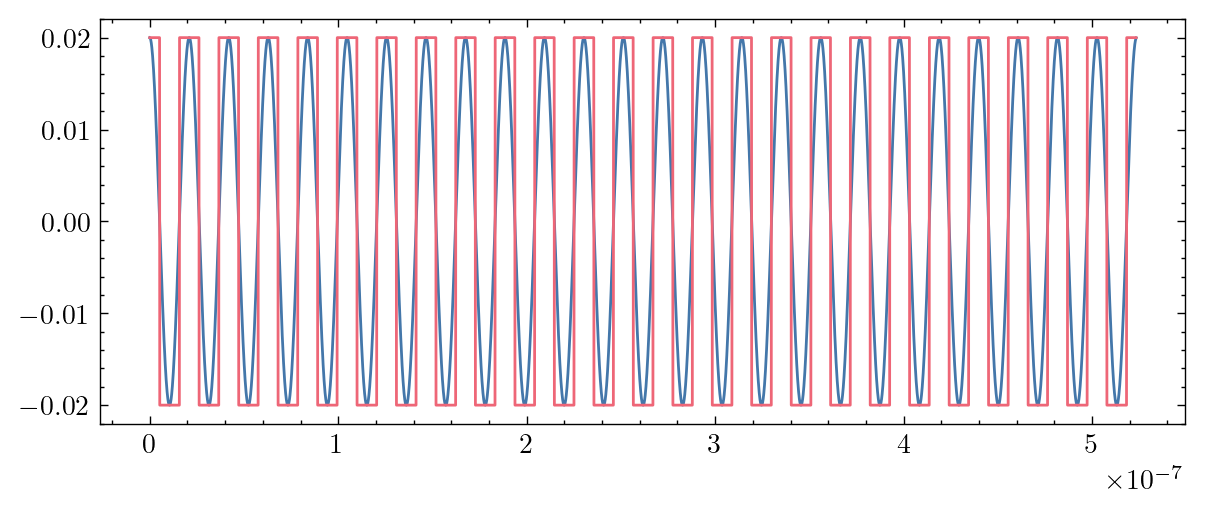

In [2]:
amplitude   = 0.02
freq        = 3.0
time_step   = 1e-10
N_periods   = 50
N_voltages  = int(N_periods*np.pi/(freq*1e8*time_step))
time_steps  = time_step*np.arange(N_voltages)
x_vals      = amplitude*np.cos(freq*time_steps*1e8)
y_target    = amplitude*signal.square(freq*time_steps*1e8-3*np.pi/2)
x_scaled    = (x_vals-np.mean(x_vals))/np.std(x_vals)
y_scaled    = (y_target-np.mean(y_target))/np.std(y_target)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot()
    ax.plot(time_steps, x_vals)
    ax.plot(time_steps, y_target)

In [53]:
results = pd.DataFrame()
errors  = pd.DataFrame()
volts   = []
N_vals  = 1000 #len(y_target)-1

n = 0
for i in range(10):
    for j in range(5):
        df_tmp              = pd.read_csv(f"../data/random_sample_phase/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        results.loc[:,n]    = df_tmp.iloc[-N_vals:,-2].reset_index(drop=True)
        errors.loc[:,n]     = df_tmp.iloc[-N_vals:,-1].reset_index(drop=True)
        n                   = n + 1

results_norm    = (results-results.mean())/results.std()
results_norm    = results_norm.round(4)
mse             = np.sum((results_norm - y_target[-N_vals:,np.newaxis])**2, axis=0)
min_val         = np.argmin(mse)
results_norm

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.0824,0.0970,-0.6264,1.1734,-1.4912,0.8981,-1.3173,-0.0521,1.1822,-0.6357,...,1.1063,-0.4451,-0.8872,-0.9635,-0.4773,0.3791,1.2806,-1.1749,-0.4049,-0.5866
1,-0.9821,0.0817,-0.5805,1.1641,-1.4314,0.8160,-1.2714,0.0074,1.2364,-0.6656,...,1.1614,-0.4486,-0.8629,-0.9312,-0.4104,0.4399,1.1778,-1.1266,-0.3761,-0.5993
2,-0.8777,0.1398,-0.6522,1.1622,-1.4105,0.8936,-1.1390,-0.0287,1.2065,-0.6511,...,1.1299,-0.3865,-0.8586,-0.9874,-0.2971,0.4486,1.3178,-0.9929,-0.2903,-0.5797
3,-0.8970,0.2075,-0.5717,1.3431,-1.4826,0.9085,-1.2275,0.0109,1.2412,-0.6148,...,1.1367,-0.1992,-0.8143,-0.8708,-0.3899,0.5363,1.2846,-1.0251,-0.2549,-0.5262
4,-0.8455,0.2811,-0.6232,1.2985,-1.4371,0.9187,-1.2436,0.1519,1.3267,-0.5025,...,1.1267,-0.1953,-0.8450,-0.9808,-0.3120,0.4136,1.3604,-1.1923,-0.1899,-0.4598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.2308,-1.6004,-1.5000,-0.8884,-0.1252,-1.2197,-1.0065,-1.5009,-0.8373,-1.3137,...,-1.0909,-1.4518,-1.1338,-1.0363,-1.0981,-1.4042,-0.9641,-1.2297,-1.3586,-1.3691
996,-1.2278,-1.5954,-1.6024,-0.8590,-0.2122,-1.2890,-1.0653,-1.4359,-0.7949,-1.3367,...,-1.2058,-1.4394,-1.0892,-1.0317,-1.1947,-1.3851,-0.9487,-1.2978,-1.3321,-1.3519
997,-1.3149,-1.6435,-1.6155,-0.8329,-0.2149,-1.2283,-1.0990,-1.4919,-0.7812,-1.3678,...,-1.0396,-1.5118,-1.1701,-1.0096,-1.2946,-1.3553,-0.8249,-1.3445,-1.3272,-1.3244
998,-1.3678,-1.6117,-1.3952,-0.6760,-0.2609,-1.1524,-1.1104,-1.3892,-0.8381,-1.3536,...,-1.1255,-1.4599,-1.1737,-1.0889,-1.3211,-1.3324,-0.9508,-1.3661,-1.3965,-1.3145


(0.0, 200.0)

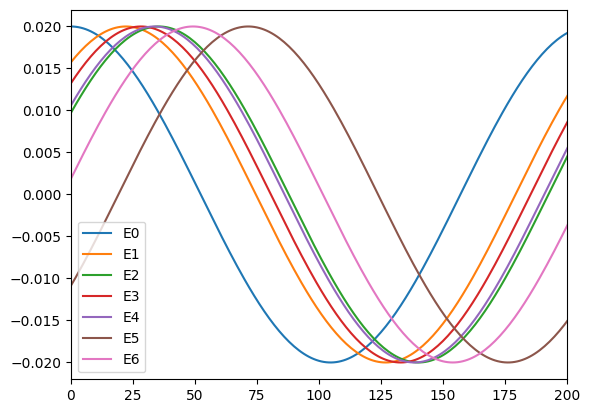

In [73]:
df_tmp.loc[:,'E0':'E6'].plot()
plt.xlim(0,200)

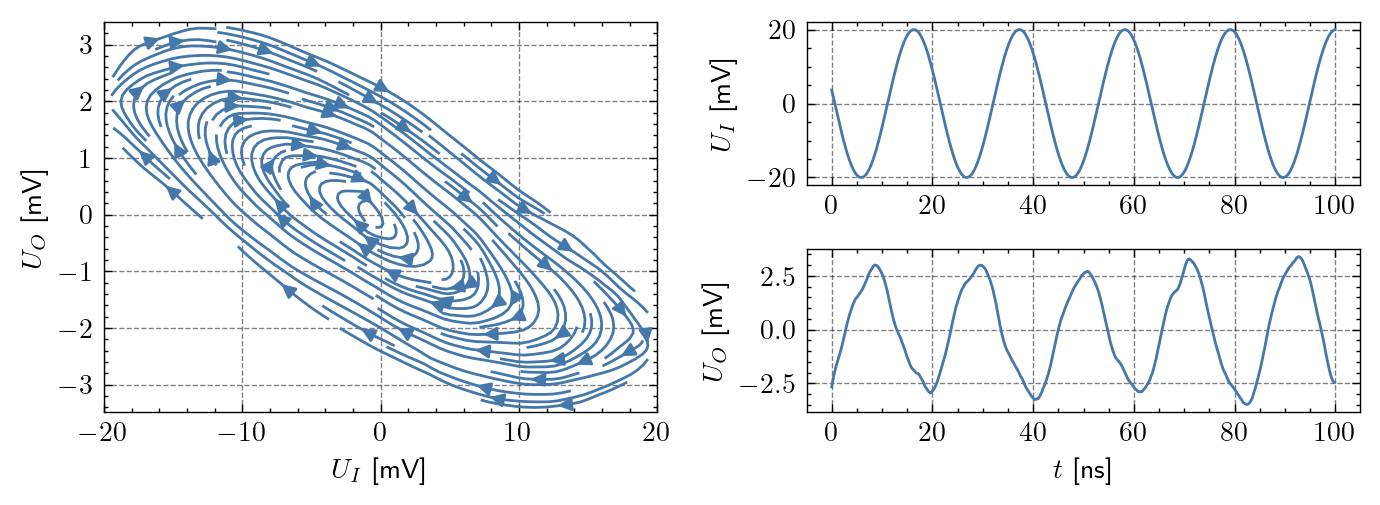

In [67]:
t       = time_steps[:N_vals]*1e9
x       = x_vals[-N_vals:]*1000
y       = signal.savgol_filter(results[15]*1000, window_length=31, polyorder=3)
# y       = results[min_val]*1000
dx_dt   = np.gradient(x, t)
dy_dt   = np.gradient(y, t)
X, Y    = np.meshgrid(np.linspace(np.min(x), np.max(x), 100),
                      np.linspace(np.min(y), np.max(y), 100))
points = np.array([x, y]).T

U = griddata(points, dx_dt, (X, Y), method='linear')
V = griddata(points, dy_dt, (X, Y), method='linear')
U = np.ma.masked_invalid(U)
V = np.ma.masked_invalid(V)

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)
    ax.streamplot(X, Y, U, V, density=2)
    # ax.streamplot(X, Y, U, V, density=2, start_points=[[1,1]])
    ax.set_xlim(-20,20)
    ax.set_xlabel("$U_I$ [mV]")
    ax.set_ylabel("$U_O$ [mV]")

    ax  = fig.add_subplot(2,2,2)
    ax.plot(t, x)
    ax.set_ylabel("$U_I$ [mV]")

    ax  = fig.add_subplot(2,2,4)
    ax.plot(t, y)
    ax.set_ylabel("$U_O$ [mV]")
    ax.set_xlabel("$t$ [ns]")

---